In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Preprocessing 

In [2]:
# Hastahane verisi üzerinde çalışacağız, veri setini yüklüyorum.
df = pd.read_csv("community_health.csv")
df.head(3)

,age,gender,race/ethnicity,weight,height,visits
0,47,female,group D,247,65,28
1,26,male,group C,283,66,23
2,26,male,group B,201,68,14


In [3]:
# Veri hakında bilgi alıyorum.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             1000 non-null   int64 
 1   gender          1000 non-null   object
 2   race/ethnicity  1000 non-null   object
 3   weight          1000 non-null   int64 
 4   height          1000 non-null   int64 
 5   visits          1000 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 47.0+ KB


In [4]:
# Eksik veri kontrolu yapıyorum.
df.isnull().sum()

age               0
gender            0
race/ethnicity    0
weight            0
height            0
visits            0
dtype: int64

In [5]:
# Etnik kökenin, ziyaret sayısı ile korelasyonu çok düşük olacağından bu veriyi çıkartıyorum.
df = df.drop(columns="race/ethnicity", axis=1)

In [6]:
# Kategorisel cinsiyet verisini dummy methodu ile numarik hale getiriyorum.
df=pd.get_dummies(df,columns=["gender"], drop_first=True, dtype=int)

In [7]:
# Kolon isimlerini türkçe yapıyorum(isteğe bağlı).
df.rename(columns={
        "age" : "yas",
        "gender_male" : "cinsiyet",
        "weight" : "kilo",
        "height" : "boy",
        "visits" : "ziyaretler"
    }, inplace=True
)

In [8]:
#Kilo ve boy verilerini SI birim sitemine göre güncelliyorum.(kg ve cm)
df["kilo"] = round(df["kilo"] * 0.45)
df["boy"] = round(df["boy"] * 2.54)

In [9]:
df.head(3)

,yas,kilo,boy,ziyaretler,cinsiyet
0,47,111.0,165.0,28,0
1,26,127.0,168.0,23,1
2,26,90.0,173.0,14,1


In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
yas,1000.0,45.019,14.839166,0.0,36.0,45.0,55.0,89.0
kilo,1000.0,89.574,23.759736,20.0,74.0,89.0,106.0,160.0
boy,1000.0,170.914,15.947694,117.0,160.0,170.0,183.0,218.0
ziyaretler,1000.0,19.956,6.455055,2.0,15.0,20.0,24.0,40.0
cinsiyet,1000.0,0.481,0.499889,0.0,0.0,0.0,1.0,1.0


In [11]:
df.corr(numeric_only=True)

,yas,kilo,boy,ziyaretler,cinsiyet
yas,1.000000,-0.084586,-0.063454,0.539543,0.023866
kilo,-0.084586,1.000000,0.141370,0.543433,0.272045
boy,-0.063454,0.141370,1.000000,-0.386140,0.296501
ziyaretler,0.539543,0.543433,-0.386140,1.000000,0.066747
cinsiyet,0.023866,0.272045,0.296501,0.066747,1.000000


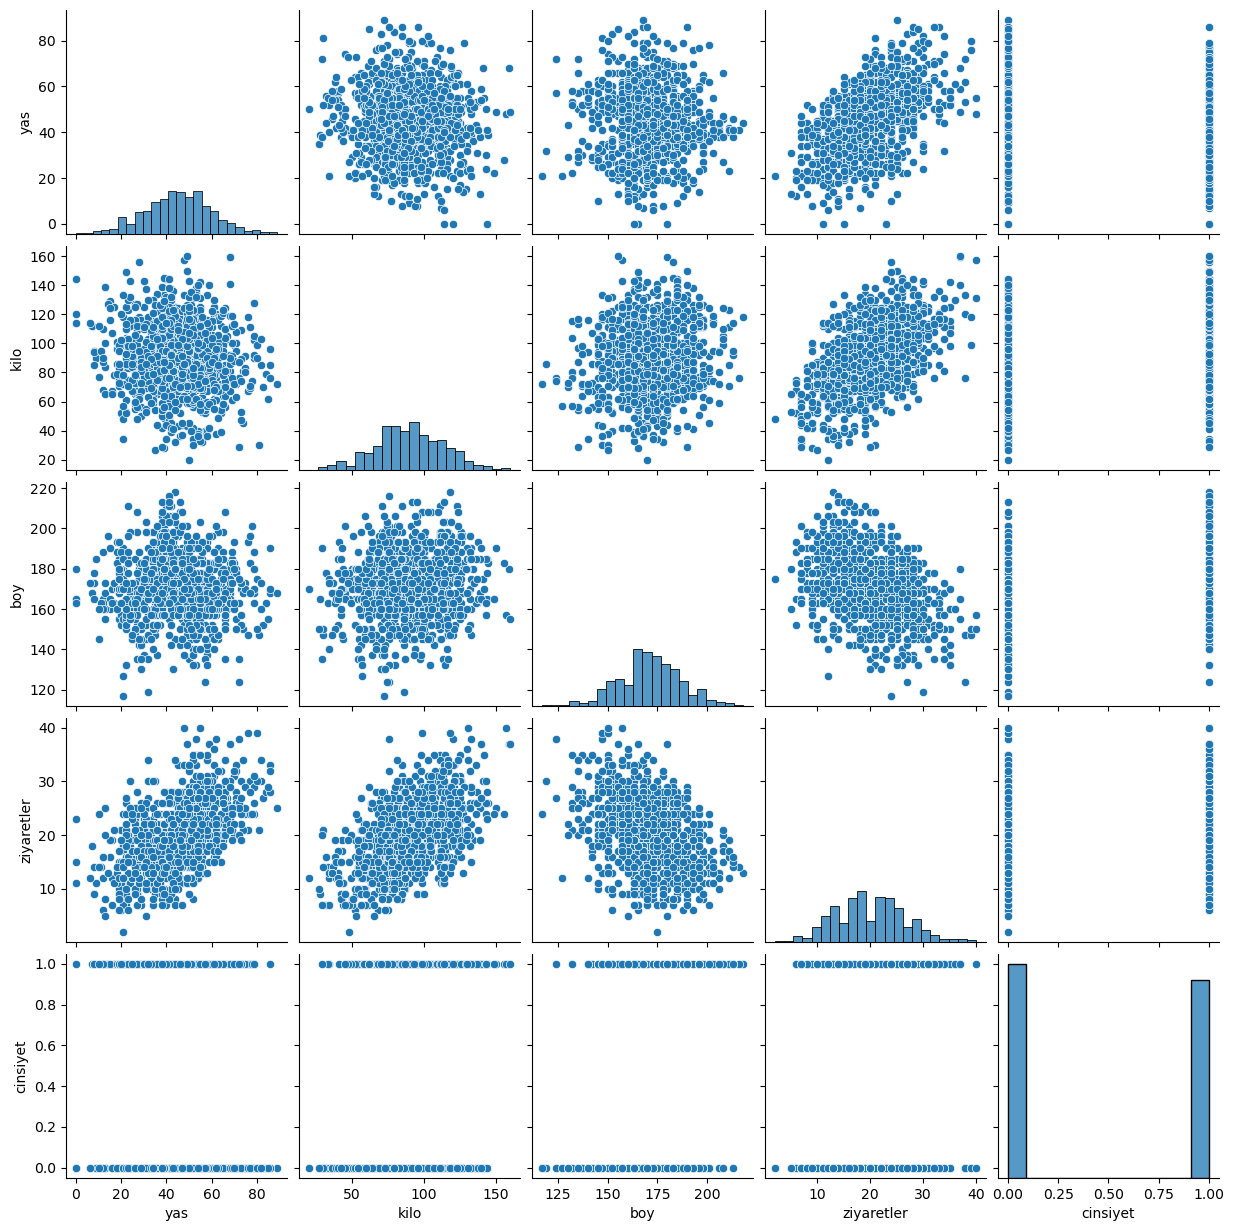

In [12]:
sns.pairplot(df);

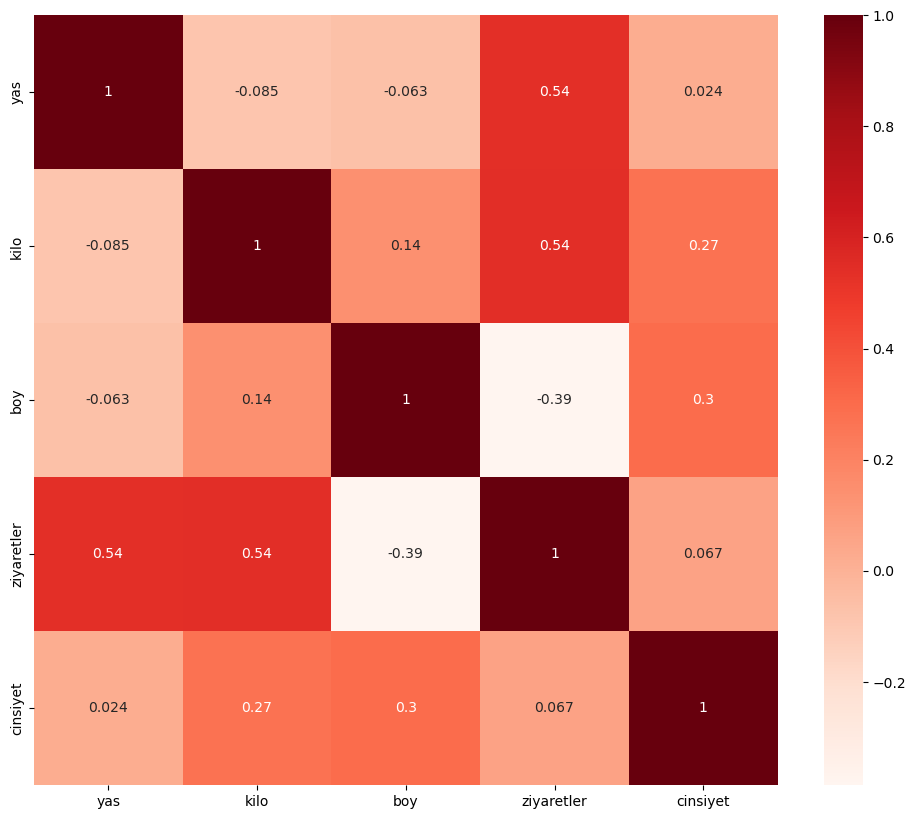

In [13]:
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show;

In [14]:
# Hedef değişken ve bağımsız değişkenleri atıyorum
X = df.drop("ziyaretler", axis=1)
y = df["ziyaretler"]

# Veri setini eğitim ve test verisi olarak ayırıyorum.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state = 1)

print("x_train shape:",X_train.shape)
print("x_test shape:",X_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

x_train shape: (800, 4)
x_test shape: (200, 4)
y_train shape: (800,)
y_test shape: (200,)


In [15]:
# Skorları saklayacağım sözlük yapılarını oluşturuyorum (daha sonra verileri tablo olarak gözlemleyeceğiz).
result_train = {}
result_test = {}

--------------------------

* Çeşitli regresyon yöntemleriyle model oluşturacağım ve model skorlarını birbirleyile karşılaştıracağız.
    * Lineer Regression
    * Lasso Regression
    * Ridge Regression
    * Elastic-Net Regression
    * Polynomial Regression

# Linear Regression

In [16]:
# Logistic regression ile model kurma
# CV değerini 5 veriyorum(her model için 5 vereceğim).
from sklearn.linear_model import LinearRegression

model = LinearRegression()
accuracies = cross_val_score(model, X_train, y_train, cv=5)
model.fit(X_train,y_train)

print("Train Score:",np.mean(accuracies)) # 5 skorun ortalaması
print("Test Score:",model.score(X_test,y_test))

Train Score: 0.8304241259447865
Test Score: 0.8261704451848263


In [17]:
# Skorları yukarıda oluşturduğum sözlüklere ekliyorum.
result_train["Lin. Reg. Train Score"] = np.mean(accuracies)
result_test["Lin. Reg. Test Score"] = model.score(X_test,y_test)

In [18]:
print(f"Sabit Değer: {model.intercept_} \nHer Sabitin Katsayısı: {model.coef_}")

Sabit Değer: 23.18318495243389 
Her Sabitin Katsayısı: [ 0.24737798  0.17847747 -0.17819894  0.12689225]


-------------
* Tahmin modeli şu şekildedir.
    * y = b + a1x1 + a2x2 + ....
* y = 23.183 + 0.247(Yaş) + 0.178(Kilo) + -0.178(Boy) + 0.126(Cinsiyet)
-------------------

In [19]:
# Tahmin edilen ve gerçek ziyaret sayılarını görelim.
df["tahmin_ziyaretler"] = model.predict(X)
print(df[["ziyaretler", "tahmin_ziyaretler",]].head(5))

   ziyaretler  tahmin_ziyaretler
0          28          25.218124
1          23          22.471121
2          14          14.976461
3          21          19.088104
4          27          25.358003


In [20]:
# Kendi tahminim.
yas = 33
kilo = 105
boy = 186
cinsiyet = 0
fiyat = model.predict([[yas,kilo,boy,cinsiyet]])
print("Tahmini hastane ziyareti sayısı:", round(fiyat[0]), "kez")

Tahmini hastane ziyareti sayısı: 17 kez


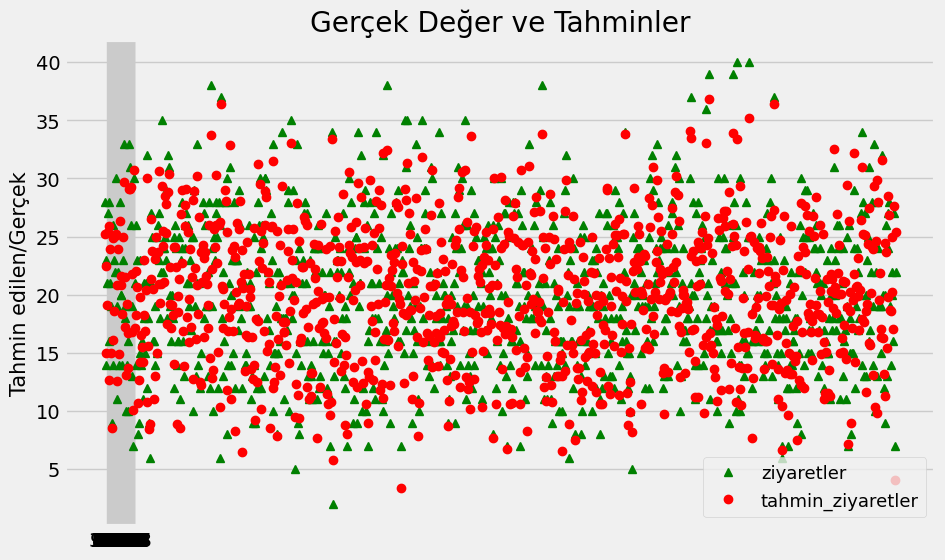

In [21]:
# Gerçek ve tahmin grafiği 
plt.style.use("fivethirtyeight")
plt.figure(figsize=(10,6))
plt.title("Gerçek Değer ve Tahminler")
plt.xticks(df["ziyaretler"], df.index.values)
plt.plot(df["ziyaretler"], "g^", label="ziyaretler")
plt.xticks(df["tahmin_ziyaretler"], df.index.values)
plt.plot(df["tahmin_ziyaretler"], "ro", label="tahmin_ziyaretler")
plt.ylabel("Tahmin edilen/Gerçek", fontsize=15)
plt.legend(fontsize=13, loc="lower right")
plt.show;

* Diğer modeller üzerinde skorlara bakalım.

------------------
--------------------

# Lasso Model

In [22]:
# Grid search ile modeli kuruyorum.
from sklearn.linear_model import Lasso

grid = {"alpha" : [1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,2,3,4,5,10,20,30,50]}

lasso = Lasso(random_state = 1)
lasso_cv = GridSearchCV(lasso, grid, scoring="r2",cv=5)
lasso_cv.fit(X_train, y_train)

print("Hyperparameters:",lasso_cv.best_params_)
print("Train Score:",lasso_cv.best_score_)
print("Test Score:",lasso_cv.score(X_test,y_test))


Hyperparameters: {'alpha': 0.01}
Train Score: 0.8304570940338103
Test Score: 0.8262139840151621


In [23]:
result_train["Lasso Train Score"] = lasso_cv.best_score_
result_test["Lasso Test Score"] = lasso_cv.score(X_test,y_test)

---------------------
--------------------

# Ridge Model

In [24]:
from sklearn.linear_model import Ridge

grid = {"alpha" : [1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,2,3,4,5,10,20,30,50]}

ridge = Ridge(random_state=1)
ridge_cv = GridSearchCV(ridge, grid, scoring="r2", cv=5)
ridge_cv.fit(X_train, y_train)

print("Hyperparameters:",ridge_cv.best_params_)
print("Train Score:",ridge_cv.best_score_)
print("Test Score:",ridge_cv.score(X_test,y_test))

Hyperparameters: {'alpha': 50}
Train Score: 0.8304979915144219
Test Score: 0.8262020281135869


In [25]:
result_train["Ridge Train Score"] = ridge_cv.best_score_
result_test["Ridge Test Score"] = ridge_cv.score(X_test,y_test)

-------------------
-----------------

# Elastic-Net Model

In [26]:
from sklearn.linear_model import ElasticNet

grid = {"alpha" : [1e-15,1e-10,1e-8,1e-4,1e-3,1e-2,1,2,3,4,5,10,20,30,50],
                "l1_ratio" : [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]}

enet = ElasticNet(random_state=1)
enet_cv = GridSearchCV(enet, grid, scoring="r2", cv=5)
enet_cv.fit(X_train, y_train)

print("Hyperparameters:",enet_cv.best_params_)
print("Train Score:",enet_cv.best_score_)
print("Test Score:",enet_cv.score(X_test,y_test))

Hyperparameters: {'alpha': 1, 'l1_ratio': 0.1}
Train Score: 0.8306046968217649
Test Score: 0.8262576941372571


In [27]:
result_train["Elastic-Net Train Score"] = enet_cv.best_score_
result_test["Elastic-Net Test Score"] = enet_cv.score(X_test,y_test)

---------------------------------------
---------------------------

# Polynomial Regression

In [28]:
# Bağımsız değişkenleri yeniden ölçeklendiriyorum.
s_scaller = StandardScaler()
X = s_scaller.fit_transform(X)

# Veri setini eğitim ve test verisi olarak ayırıyorum.
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 1)

In [29]:
X_train

array([[-0.54066466,  0.86011986,  0.57002264,  1.03875025],
       [ 1.34717803,  1.32331963,  1.07191358,  1.03875025],
       [ 0.67294849, -0.31893409, -0.18281378, -0.96269532],
       ...,
       [-1.61943191, -1.37166084, -2.75500486, -0.96269532],
       [ 0.47067964,  1.07066521, -2.44132302, -0.96269532],
       [ 1.01006326,  0.90222893, -1.18659566, -0.96269532]])

In [30]:
from sklearn.preprocessing import PolynomialFeatures

# Öznitelik değişkenlerinin polinom derecelerini oluşturup her bir polinom derecesi ile oluşturulan modelin hata skorunu hesaplatıyoruz.
# Hata skorunu RMSE'ü kulanıyoruz.
rmses = []
degrees = np.arange(1,10);
min_rmse, min_deg = 1e10, 0

for deg in degrees:
    # Eğitim seti öznitelikleri
    poly_features = PolynomialFeatures(degree=deg, include_bias=False)
    X_poly_train= poly_features.fit_transform(X_train)
    # Doğrusal regresyon
    poly_reg = LinearRegression()
    poly_reg.fit(X_poly_train, y_train)
    # Test seti ile karşılaştırılması
    X_poly_test = poly_features.fit_transform(X_test)
    poly_predict = poly_reg.predict(X_poly_test)
    poly_mse = mean_absolute_error(y_test, poly_predict)
    poly_rmse = np.sqrt(poly_mse)
    rmses.append(poly_rmse)
    # Çapraz doğrulama ile polinom derecesi
    if min_rmse > poly_rmse:
        min_rmse = poly_rmse
        min_deg = deg

print("En iyi model {} RMSE hata skoru veren, {} polinom dercesi ile sağlanıyor".format(min_rmse,min_deg))


En iyi model 1.4755568320742476 RMSE hata skoru veren, 2 polinom dercesi ile sağlanıyor


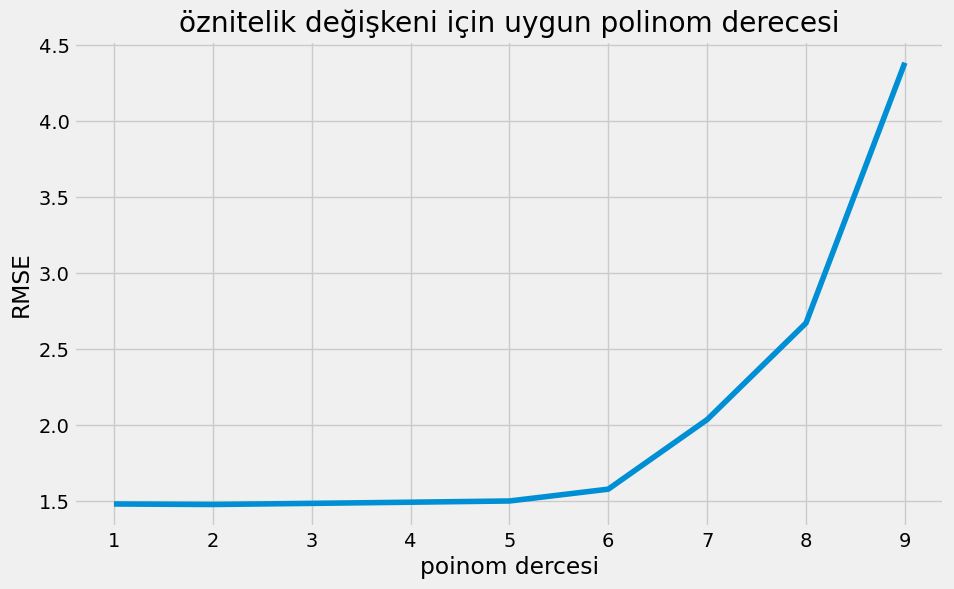

In [31]:
# Tüm polinom dereceleri için rmse skorları grafiği
plt.figure(figsize=(10, 6))
plt.title("öznitelik değişkeni için uygun polinom derecesi")
sns.lineplot(x=degrees, y=rmses)
plt.xlabel("poinom dercesi")
plt.ylabel("RMSE");

In [32]:
# Uygun polinom derecesine göre modeli oluşturuyorum.
polinom_dercesi = PolynomialFeatures(degree=2)
X_train_polinom = polinom_dercesi.fit_transform(X_train) 
X_test_polinom = polinom_dercesi.fit_transform(X_test)

In [33]:
model = LinearRegression()
accuracies = cross_val_score(model, X_train_polinom, y_train, cv=5)
model.fit(X_train_polinom,y_train)

print("Train Score:",np.mean(accuracies)) # 5 skorun ortalaması
print("Test Score:",model.score(X_test_polinom,y_test))

Train Score: 0.8487455329458807
Test Score: 0.8325909429241707


In [34]:
result_train["Poly. Reg. Train Score"] = np.mean(accuracies)
result_test["Poly. Reg. Test Score"] = model.score(X_test_polinom,y_test)

In [35]:
# Modelerin eğitim verisi üzerindeki skorları.
df_train = pd.DataFrame.from_dict(result_train,orient = "index",columns=["R2-Score"])
df_train

,R2-Score
Lin. Reg. Train Score,0.830424
Lasso Train Score,0.830457
Ridge Train Score,0.830498
Elastic-Net Train Score,0.830605
Poly. Reg. Train Score,0.848746


In [36]:
# Modelerin test verisi üzerindeki skorları.
df_test = pd.DataFrame.from_dict(result_test,orient = "index",columns=["R2-Score"])
df_test

,R2-Score
Lin. Reg. Test Score,0.826170
Lasso Test Score,0.826214
Ridge Test Score,0.826202
Elastic-Net Test Score,0.826258
Poly. Reg. Test Score,0.832591


--------------------